In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/d2nn

/content/drive/My Drive/d2nn


In [3]:
import tensorflow as tf
import numpy as np
from math import pi
from tensorflow.keras import layers
from scipy.fftpack import fft2
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import pprint
import keras

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sat Oct 31 18:40:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
class batch_normalize_2_images(layers.Layer):

    def __init__(self):
        super(batch_normalize_2_images, self).__init__()

    def call(self, x, y):
        epsilon = 1e-3
        stack = tf.math.divide(tf.math.add(x, y), tf.constant(2.0, 'complex64'))
        batch_mean2, batch_var2 = tf.nn.moments(x=stack,axes=[0])
        batch_mean2 = tf.cast(batch_mean2, 'float32')
        batch_var2 = tf.cast(batch_var2, 'float32')
        scale2 = tf.cast(tf.Variable(tf.ones(stack.get_shape())), 'float32')
        beta2 = tf.cast(tf.Variable(tf.zeros(stack.get_shape())), 'float32')
        BN_x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, beta2, scale2, epsilon)
        BN_y = tf.nn.batch_normalization(y, batch_mean2, batch_var2, beta2, scale2, epsilon)
        return BN_x, BN_y

class normalize_2_complex_images(layers.Layer):

    def __init__(self):
        super(normalize_2_complex_images, self).__init__()

    def call(self, x, y):
        [norm_x, norm_y] = tf.map_fn(self.apply_conv, [x, y])
        return [norm_x, norm_y]

    def apply_conv(self, xy):
        [x, y] = xy
        x_max = tf.reduce_max(input_tensor=tf.abs(x))
        y_max = tf.reduce_max(input_tensor=tf.abs(y))
        max_val = tf.cond(pred=tf.math.greater(x_max, y_max), true_fn=lambda: x_max, false_fn=lambda: y_max)
        norm_x = tf.math.divide(x, tf.cast(max_val, 'complex64'))
        norm_y = tf.math.divide(y, tf.cast(max_val, 'complex64'))
        return [norm_x, norm_y]

class scale_2_complex_images(layers.Layer):
    ''' Resizes images to original shape x scale
            Original shape x scale must be integer number
            Tensorflow does not support resizing complex valued tensors
            tf.image.resize 
    '''
    def __init__(self, scale):
        super(scale_2_complex_images, self).__init__()
        self.scale = scale

    def call(self, x, y):
        sx = tf.map_fn(self.apply_scale, x)
        sy = tf.map_fn(self.apply_scale, y)
        return [sx, sy]

    def apply_scale(self, x):
        ''' Takes 2-D Tensor, returns scaled 2-D Tensor '''
        s = tf.identity(x)
        s_shape = tf.shape(input=s)
        s = tf.reshape(s, [s_shape[0], s_shape[1], 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale, 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.transpose(a=s, perm=[0, 2, 1])
        s = tf.reshape(s, [s_shape[0]*self.scale, s_shape[1]*self.scale])
        return s

class propagation_layer_2d(layers.Layer):
    ''' Propagator layer with fft convolution implementation
        fft empirically determined to be faster for large kernels
        Input to fsp layer must be physical values
    '''
    def __init__(self, source_grid_size, lc_array_size, dx, dist, wavelength, prop_type):
        super(propagation_layer_2d, self).__init__()
        self.source_grid_size = source_grid_size
        self.lc_array_size = lc_array_size
        self.dx = dx
        self.prop_dist = dist
        self.wavelength = wavelength
        if prop_type == 'TF':
            self.propagator = self.make_TF_propagator()
        elif prop_type == 'RS':
            self.propagator = self.make_RS_propagator()

    def make_TF_propagator(self):
        L = self.lc_array_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')

    def make_RS_propagator(self):
        lc_array_size = self.lc_array_size
        k = 1.0/self.wavelength
        x = np.linspace(-lc_array_size/2.0, lc_array_size/2.0, int(self.source_grid_size))
        #dx = tf.constant(lc_array_size/self.source_grid_size, 'complex64')
        dx = tf.constant(1.0, 'complex64')
        [rhox, rhoy] = np.meshgrid(x, x)
        rho2 = np.sqrt(rhox**2 + rhoy**2)
        #z = tf.cast(tf.identity(self.prop_dist), 'complex64') 
        z_var = tf.identity(self.prop_dist)
        z = tf.cast(z_var, 'complex64')
        imag_j = tf.constant(-1j, 'complex64')
        k = tf.constant(k, 'complex64')
        rho2 = tf.constant(rho2, 'complex64')
        one = tf.constant(1.0, 'complex64')
        two = tf.constant(2.0, 'complex64')
        pi_const = tf.constant(pi, 'complex64')
        a = tf.math.divide(-imag_j*k*z, (rho2+tf.math.square(z)))
        b = tf.math.exp(imag_j*two*pi_const*k*tf.math.sqrt(rho2 + tf.math.square(z)))
        c = (one + tf.math.divide(imag_j, two*pi_const*k*tf.math.sqrt(rho2+tf.math.square(z))))

        # h = tf.constant(-1j*k*z/(rho2+z**2)*np.exp(1j*2*pi*k*np.sqrt(rho2 + z**2))*(1+ 1j/2/pi/k/np.sqrt(rho2+z**2)), 'complex64')
        h = a*b*c
        H = tf.math.multiply(tf.signal.fft2d(tf.signal.fftshift(h)), tf.math.square(dx))
        return H

    def call(self, x, y):
        x = tf.cast(x, 'complex64')
        y = tf.cast(y, 'complex64')
        [conv_x, conv_y] = tf.map_fn(self.apply_conv, [x, y])
        return [conv_x, conv_y]

    def apply_conv(self, xy):
    	[x, y] = xy
    	conv_x = self.conv2dfft(self.propagator, x)
    	conv_y = self.conv2dfft(self.propagator, y)
    	return [conv_x, conv_y]

    def conv2dfft(self, A, B):
    	B = tf.signal.fft2d(tf.signal.fftshift(B))
    	fftAB = tf.math.multiply(A, B)
    	return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))

class lc_layer(layers.Layer):
    ''' Implements Liquid Crystal layer based on paper
    	reference: 
        Make 28x28 Weights
        Scale weight matrix to image size
        Update weights
    '''
    def __init__(self, num_weights, scale, wavelength, layer_type):
        super(lc_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.layer_type = layer_type
        self.wavelength = wavelength
        if layer_type == 'rotator':
            self.theta = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True)
        elif layer_type == 'lc':
            self.ne_theta = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True)
            Ae, Be, Ce = 1.6708, 0.0081, 0.0024
            Ao, Bo, Co = 1.5139, 0.0052, 0.0008
            wavelength_um= wavelength/1e-6
            self.ne = Ae + Be/wavelength_um**2 + Ce/wavelength_um**4
            self.no = Ao + Bo/wavelength_um**2 + Co/wavelength_um**4
            self.d = 1e-4

    def call(self, x, y):
        self.batch_size = x.get_shape()[0]
        if self.layer_type == 'rotator':
            scaled_theta = self.scale_weights() 
            return self.rotator(x, y, scaled_theta)
        elif self.layer_type == 'lc':
            scaled_ne_theta = self.scale_weights() 
            return self.lc(x, y, scaled_ne_theta)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        if self.layer_type == 'lc':
            w = tf.identity(self.ne_theta)
        elif self.layer_type == 'rotator':
            w = tf.identity(self.theta)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w

    def lc(self, x, y, ne_theta):
        d = self.d
        ne_theta = tf.cast(ne_theta, 'complex64')
        wavelength = self.wavelength
        pidlambda_term = pi*d/wavelength
        beta = pidlambda_term*(ne_theta - self.no)
        phi = pidlambda_term*(ne_theta + self.no)
        gamma = tf.math.sqrt(np.square(pi/2.0) + tf.math.square(beta))

        a = pi/2.0/gamma*tf.math.sin(gamma)
        b = tf.math.cos(gamma) + 1j*beta/gamma*tf.math.sin(gamma)
        c = -tf.math.cos(gamma) + 1j*beta/gamma*tf.math.sin(gamma)
        d = pi/2.0/gamma*tf.math.sin(gamma)

        return [tf.math.exp(-1j*phi)*(a*x + b*y), tf.math.exp(-1j*phi)*(c*x + d*y)]

    def rotator(self, x, y, theta):
        outputx = tf.cast(tf.math.cos(theta), 'complex64')*x + tf.cast(tf.math.sin(theta), 'complex64')*y
        outputy = -tf.cast(tf.math.sin(theta), 'complex64')*x + tf.cast(tf.math.cos(theta), 'complex64')*y
        return [outputx, outputy]

In [6]:
class batch_normalize_1_image(layers.Layer):

    def __init__(self):
        super(batch_normalize_1_image, self).__init__()

    def call(self, x):
        epsilon = 1e-3
        stack = tf.math.divide(x, tf.constant(2.0, 'complex64'))
        batch_mean2, batch_var2 = tf.nn.moments(x=stack,axes=[0])
        batch_mean2 = tf.cast(batch_mean2, 'float32')
        batch_var2 = tf.cast(batch_var2, 'float32')
        scale2 = tf.cast(tf.Variable(tf.ones(stack.get_shape())), 'float32')
        beta2 = tf.cast(tf.Variable(tf.zeros(stack.get_shape())), 'float32')
        BN_x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, beta2, scale2, epsilon)
        return BN_x

class normalize_1_complex_image(layers.Layer):

    def __init__(self):
        super(normalize_1_complex_image, self).__init__()

    def call(self, x):
        norm_x = tf.map_fn(self.apply_conv, x)
        return norm_x

    def apply_conv(self, x):
        x_max = tf.reduce_max(input_tensor=tf.abs(x))
        norm_x = tf.math.divide(x, tf.cast(x_max, 'complex64'))
        return norm_x

class scale_1_complex_image(layers.Layer):
    ''' Resizes images to original shape x scale
            Original shape x scale must be integer number
            Tensorflow does not support resizing complex valued tensors
            tf.image.resize 
    '''
    def __init__(self, scale):
        super(scale_1_complex_image, self).__init__()
        self.scale = scale

    def call(self, x):
        sx = tf.map_fn(self.apply_scale, x)
        return sx

    def apply_scale(self, x):
        ''' Takes 2-D Tensor, returns scaled 2-D Tensor '''
        s = tf.identity(x)
        s_shape = tf.shape(input=s)
        s = tf.reshape(s, [s_shape[0], s_shape[1], 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale, 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.transpose(a=s, perm=[0, 2, 1])
        s = tf.reshape(s, [s_shape[0]*self.scale, s_shape[1]*self.scale])
        return s

class propagation_layer_1d(layers.Layer):
    ''' Propagator layer with fft convolution implementation
        fft empirically determined to be faster for large kernels
        Input to fsp layer must be physical values
    '''
    def __init__(self, source_grid_size, lc_array_size, dx, dist, wavelength, prop_type):
        super(propagation_layer_1d, self).__init__()
        self.source_grid_size = source_grid_size
        self.lc_array_size = lc_array_size
        self.dx = dx
        self.prop_dist = dist
        #self.prop_dist = tf.Variable(initial_value = 0.001, trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 2e-3), dtype = 'float32')
        self.wavelength = wavelength
        self.propagator = self.make_TF_propagator()

    def make_TF_propagator(self):
        L = self.lc_array_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')

    def call(self, x):
        x = tf.cast(x, 'complex64')
        conv_x = tf.map_fn(self.apply_conv, x)
        return conv_x

    def apply_conv(self, x):
    	  conv_x = self.conv2dfft(self.propagator, x)
    	  return conv_x
             
    def conv2dfft(self, A, B):
    	B = tf.signal.fft2d(tf.signal.fftshift(B))
    	fftAB = tf.math.multiply(A, B)
    	return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))

class dmd_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(dmd_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.transmission = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.dmd(x, scaled_weights)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        w = tf.identity(self.transmission)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def dmd(self, x, scaled_weights):
        return tf.math.multiply(x, tf.cast(scaled_weights, 'complex64'))

class phaseret_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(phaseret_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.phase = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 2*pi))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.phaseret(x, scaled_weights)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        w = tf.identity(self.phase)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def phaseret(self, x, scaled_weights):
        return tf.math.multiply(x, tf.math.exp(tf.cast(scaled_weights, 'complex64')))

class fuse(layers.Layer):

    def __init__(self):
        super(fuse, self).__init__()
        self.rot_weights = tf.Variable(initial_value = np.random.rand(1, 10), trainable = True, dtype = tf.float32, name = 'rot_weights')
        self.amp_weights = tf.Variable(initial_value = np.random.rand(1, 10), trainable = True, dtype = tf.float32, name = 'amp_weights')
        self.phase_weights = tf.Variable(initial_value = np.random.rand(1, 10), trainable = True, dtype = tf.float32, name = 'phase_weights')
        # self.rot_weights = tf.Variable(initial_value = 0.1, trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1), dtype = tf.float32, name = 'rot_weights')
        # self.amp_weights = tf.Variable(initial_value = 0.1, trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1), dtype = tf.float32, name = 'amp_weights')
        # self.phase_weights = tf.Variable(initial_value = 0.8, trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1), dtype = tf.float32, name = 'phase_weights')

    def call(self, rot, amp, phase):
        Ix_rot = tf.cast(tf.math.square(tf.math.abs(rot)), 'float32')
        rot_pooled = tf.map_fn(self.pool_vals, Ix_rot)
        Ix_amp = tf.cast(tf.math.square(tf.math.abs(amp)), 'float32')
        amp_pooled = tf.map_fn(self.pool_vals, Ix_amp)
        Ix_phase = tf.cast(tf.math.square(tf.math.abs(phase)), 'float32')
        phase_pooled = tf.map_fn(self.pool_vals, Ix_phase)
        print(tf.math.multiply(self.rot_weights, rot_pooled))
        return tf.math.multiply(self.rot_weights, rot_pooled) + tf.math.multiply(self.amp_weights, amp_pooled) + tf.math.multiply(self.phase_weights, phase_pooled)

    def pool_vals(self, im):
        ws = im.shape[0]//4
        pooled =  tf.nn.pool(input=tf.cast(tf.reshape(im,
                            [1, im.shape[0], im.shape[1], 1]),'float32'),
                            window_shape = (ws, ws), pooling_type = 'AVG',
                            padding = 'SAME', strides = [ws, ws])
        pooled = tf.reshape(tf.reshape(pooled, [4, 4]), [1, 16])[0][0:10]
        pooled = tf.cast(pooled, 'float32')
        return pooled

class eval_layer(layers.Layer):
    ''' Converts output to one hot form
        Applies softmax

        slice matrix/unpad
        pool
    '''
    def __init__(self):
        super(eval_layer, self).__init__()

    def call(self, x):
        Ix = tf.cast(tf.math.square(tf.math.abs(x)), 'float32')
        r = tf.map_fn(self.eval, Ix)
        r = tf.cast(r, 'float32')
        return r

    def eval(self, Ix):
        # im = self.unpad(Ix)
        im = Ix
        ws = im.shape[0]//4
        pooled =  tf.nn.pool(input=tf.cast(tf.reshape(im,
                            [1, im.shape[0], im.shape[1], 1]),'float32'),
                            window_shape = (ws, ws), pooling_type = 'AVG',
                            padding = 'SAME', strides = [ws, ws])
        pooled = tf.reshape(tf.reshape(pooled, [4, 4]), [1, 16])[0][0:10]
        pooled = tf.cast(pooled, 'float32')
        return pooled

In [7]:
class d2nn_model(object):
    def __init__(self):
        #super(YourModel, self).__init__()
        self.num_epoch = 25
        self.batch_size = 8
        self.log_step = 1
        self.lr = 1e-3
        self._build_model()

    def m(self):

        im_rescale = 10
        pixels_per_lc = 1
        input_shape = 28
        wavelength = 690e-9
        lc_size = 2e-6
        num_weights = input_shape*im_rescale
        source_grid_size = input_shape*im_rescale*pixels_per_lc
        lc_array_size = input_shape*im_rescale*lc_size
        dx = lc_size/pixels_per_lc
        evaluate = eval_layer()

        # rot layers
        prop_dist = 7.5e-3
        scale2 = scale_2_complex_images(im_rescale*pixels_per_lc)
        lc1 = lc_layer(num_weights, 1.0/pixels_per_lc, wavelength, 'rotator')
        normalize2 = normalize_2_complex_images()
        propagate_rot = propagation_layer_2d(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')

        with tf.compat.v1.variable_scope('rot_scale'):
            self.x0, self.y0 = scale2(self.pol_x, self.pol_y)
        with tf.compat.v1.variable_scope('rot1'):
            self.xl1, self.yl1 = lc1(self.x0, self.y0)
            self.xp1, self.yp1 = propagate_rot(self.xl1, self.yl1)
        with tf.compat.v1.variable_scope('rot2'):
            self.xl2, self.yl2 = lc1(self.xp1, self.yp1)
            self.xp2, self.yp2 = propagate_rot(self.xl2, self.yl2)
        with tf.compat.v1.variable_scope('rot3'):
            self.xl3, self.yl3 = lc1(self.xp2, self.yp2)
            self.xp3, self.yp3 = propagate_rot(self.xl3, self.yl3)
            self.rot, self.yn3 = normalize2(self.xp3, self.yp3)

        # amp layers
        prop_dist = 5e-3
        scale1 = scale_1_complex_image(im_rescale*pixels_per_lc)
        normalize1 = normalize_1_complex_image()
        dmd = dmd_layer(num_weights, 1.0/pixels_per_lc)
        propagate_amp = propagation_layer_1d(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')

        with tf.compat.v1.variable_scope('amp_scale'):
            self.x0 = scale1(self.pol_x)
        with tf.compat.v1.variable_scope('amp1'):
            self.xl1 = dmd(self.x0)
            self.xp1 = propagate_amp(self.xl1)
        with tf.compat.v1.variable_scope('amp2'):
            self.xl2 = dmd(self.xp1)
            self.xp2 = propagate_amp(self.xl2)
        with tf.compat.v1.variable_scope('amp3'):
            self.xl3 = dmd(self.xp2)
            self.xp3 = propagate_amp(self.xl3)
        with tf.compat.v1.variable_scope('amp4'):
            self.xl4 = dmd(self.xp3)
            self.xp4 = propagate_amp(self.xl4)
        with tf.compat.v1.variable_scope('amp5'):
            self.xl5 = dmd(self.xp4)
            self.xp5 = propagate_amp(self.xl5)
            self.amp = normalize1(self.xp5)

        # phase layers
        prop_dist = 5e-3
        phase_layer = phaseret_layer(num_weights, 1.0/pixels_per_lc)
        propagate_phase = propagation_layer_1d(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')
        
        with tf.compat.v1.variable_scope('phase_scale'):
            self.x0 = scale1(self.pol_x)
        with tf.compat.v1.variable_scope('phase1'):
            self.xl1 = phase_layer(self.x0)
            self.xp1 = propagate_phase(self.xl1)
        with tf.compat.v1.variable_scope('phase2'):
            self.xl2 = phase_layer(self.xp1)
            self.xp2 = propagate_phase(self.xl2)
        with tf.compat.v1.variable_scope('phase3'):
            self.xl3 = phase_layer(self.xp2)
            self.xp3 = propagate_phase(self.xl3)
        with tf.compat.v1.variable_scope('phase4'):
            self.xl4 = phase_layer(self.xp3)
            self.xp4 = propagate_phase(self.xl4)
        with tf.compat.v1.variable_scope('phase5'):
            self.xl5 = phase_layer(self.xp4)
            self.xp5 = propagate_phase(self.xl5)
            self.phase = normalize1(self.xp5)

        # fusion layer
        fusion_layer = fuse()
        with tf.compat.v1.variable_scope('fusion'):
            self.result = fusion_layer(self.rot, self.amp, self.phase)
        return self.result

    def _input_ops(self):
        # Placeholders
        self.pol_x = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.pol_y = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.Y = tf.compat.v1.placeholder(tf.int64, [self.batch_size])
        self.is_train = tf.compat.v1.placeholder(tf.bool)
        self.keep_prob = tf.compat.v1.placeholder(tf.float32)

    def _build_optimizer(self):
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss_op)
        #self.train_op = tf.train.GradientDescentOptimizer(self.lr*10).minimize(self.loss_op)

    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(tf.one_hot(self.Y,10)), logits=self.result))

    def _build_model(self):
        # Define input variables
        self._input_ops()
        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)
        # Build a model and get logits
        logits = self.m()
        # Compute loss
        self._loss(labels, logits)
        # Build optimizer
        self._build_optimizer()
        # Compute accuracy
        predict = tf.argmax(input=logits, axis=1)
        correct = tf.equal(predict, self.Y)
        self.confusion_matrix = tf.math.confusion_matrix(labels=self.Y, predictions=predict, num_classes=10)
        self.accuracy_op = tf.reduce_mean(input_tensor=tf.cast(correct, tf.float32))

    def train(self, sess, XX_train, XY_train, Y_train, XX_val, XY_val, Y_val):
        sess.run(tf.compat.v1.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        validations = []
        dval = []
        confusion_matrices = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        start=datetime.now()
        for epoch in range(self.num_epoch):
            XX_train, Y_train = shuffle(XX_train, Y_train)
            print('train for epoch %d' % epoch)
            for i in range(XX_train.shape[0] // self.batch_size):
                XX_ = XX_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                XY_ = XY_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.pol_x: XX_,
                             self.pol_y: XY_,
                             self.Y: Y_,
                             self.is_train: True}
                fetches = [self.train_op, self.loss_op, self.accuracy_op, self.confusion_matrix]

                _, loss, accuracy, confusion = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                confusion_matrices.append(confusion)

                runtime = datetime.now()-start

                # if step % self.log_step == 0:
                print('iteration (%d): loss = %.3f, accuracy = %.3f, time = ' %
                    (step, loss, accuracy) + str(runtime))
                step += 1
                if step % 3000 == 0:
                    self.lr = self.lr*0.7

            savestring = 'fusion_model'
    
            # Plot training curves
            plt.subplot(3, 1, 1)
            plt.plot(losses)
            plt.ylabel('Loss')
            plt.xlabel('Iteration')
            plt.grid(True)
            ## Graph 2. X: epoch, Y: training accuracy
            #plt.subplot(3, 1, 2)
            #plt.plot(accuracies)
            #plt.grid(True)
            #plt.xlabel('Iteration (Epoch {}'.format(epoch+1) + ')')
            #plt.ylabel('Training Accuracy') 

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy, confusion = self.evaluate(sess, XX_val, XY_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            validations.append(val_accuracy)
            confusion_matrices.append(confusion)
            epoches = np.arange(epoch + 1)
            if epoch > 3:      
                dval.append(np.average(np.gradient(validations[-4:])))
                plt.subplot(3, 1, 2)
                plt.plot(epoches[4:], dval)
                plt.xlabel('Epoch')
                plt.ylabel('dval/depoch')
                plt.grid(True)
                for x, y in zip(epoches[4:], dval):
                    plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)

            plt.subplot(3, 1, 3)
            plt.plot(epoches, validations)
            plt.xlabel('Epoch')
            plt.ylabel('Validation accuracy')
            plt.grid(True)
            for x, y in zip(epoches, validations):
                plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)
            plt.savefig(savestring + '.png', dpi = 1000)
            
            np.save('fuse_val_data.npy', np.vstack((epoches, validations)))
            np.save('fuse_loss_data.npy', losses)
            np.save('fuse_confusion.npy', confusion_matrices)


    def evaluate(self, sess, XX_eval, XY_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        confusion_matrix = np.zeros((10, 10))
        for i in range(XX_eval.shape[0] // self.batch_size):
            XX_ = XX_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            XY_ = XY_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.pol_x: XX_,
                         self.pol_y: XY_,
                            self.Y: Y_,
                            self.is_train: False}

            accuracy, confusion = sess.run([self.accuracy_op, self.confusion_matrix], feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
            confusion_matrix += confusion
        return eval_accuracy / eval_iter, confusion_matrix

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Tensor("fusion/fuse/Mul:0", shape=(8, 10), dtype=float32)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.306, accuracy = 0.000, time = 0:00:08.476352
iteration (1): loss = 2.280, accuracy = 0.250, time = 0:00:08.663713
iteration (2): loss = 2.278, accuracy = 0.125, time = 0:00:08.863103
iteration (3): loss = 2.310, accuracy = 0.125, time = 0:00:09.061605
iteration (4): loss = 2.318, accuracy = 0.250, time = 0:00:09.258006
iteration (5): loss = 2.292, accuracy = 0.125, time = 0:00:09.446232
iteration (6): loss = 2.303, accuracy = 0.125, time = 0:00:09.640502
iteration (7): loss = 2.315, accuracy = 0.000, time = 0:00:09.828772
iteration (8): loss = 2.293, accuracy =

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 1: validation accuracy = 0.298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 2
iteration (2000): loss = 2.170, accuracy = 0.750, time = 0:07:28.544995
iteration (2001): loss = 2.256, accuracy = 0.125, time = 0:07:28.733127
iteration (2002): loss = 2.174, accuracy = 0.375, time = 0:07:28.922990
iteration (2003): loss = 2.258, accuracy = 0.125, time = 0:07:29.123713
iteration (2004): loss = 2.224, accuracy = 0.125, time = 0:07:29.306996
iteration (2005): loss = 2.199, accuracy = 0.375, time = 0:07:29.496931
iteration (2006): loss = 2.239, accuracy = 0.125, time = 0:07:29.680187
iteration (2007): loss = 2.209, accuracy = 0.375, time = 0:07:29.867575
iteration (2008): loss = 2.219, accuracy = 0.250, time = 0:07:30.062113
iteration (2009): loss = 2.167, accuracy = 0.375, time = 0:07:30.257369
iteration (2010): loss = 2.159, accuracy = 0.500, time = 0:07:30.444792
iteration (2011): loss = 2.206, accuracy = 0.375, time = 0:07:30.635351
iteration (2012): loss = 2.220, accuracy = 0.000, time = 0:07:30.824496
iteration (2013): loss = 2.145, accuracy = 0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 2: validation accuracy = 0.365


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 3
iteration (3000): loss = 2.097, accuracy = 0.625, time = 0:11:04.647844
iteration (3001): loss = 2.152, accuracy = 0.250, time = 0:11:04.837277
iteration (3002): loss = 2.180, accuracy = 0.250, time = 0:11:05.021675
iteration (3003): loss = 2.165, accuracy = 0.250, time = 0:11:05.222105
iteration (3004): loss = 2.151, accuracy = 0.375, time = 0:11:05.406317
iteration (3005): loss = 2.128, accuracy = 0.375, time = 0:11:05.602205
iteration (3006): loss = 2.178, accuracy = 0.375, time = 0:11:05.792684
iteration (3007): loss = 2.102, accuracy = 0.375, time = 0:11:05.980897
iteration (3008): loss = 2.100, accuracy = 0.625, time = 0:11:06.182965
iteration (3009): loss = 2.129, accuracy = 0.250, time = 0:11:06.373074
iteration (3010): loss = 2.163, accuracy = 0.250, time = 0:11:06.568836
iteration (3011): loss = 2.101, accuracy = 0.625, time = 0:11:06.762097
iteration (3012): loss = 2.247, accuracy = 0.250, time = 0:11:06.957087
iteration (3013): loss = 2.156, accuracy = 0.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 3: validation accuracy = 0.375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 4
iteration (4000): loss = 2.007, accuracy = 0.625, time = 0:14:39.063506
iteration (4001): loss = 2.075, accuracy = 0.375, time = 0:14:39.254849
iteration (4002): loss = 2.080, accuracy = 0.500, time = 0:14:39.438149
iteration (4003): loss = 2.006, accuracy = 0.500, time = 0:14:39.627195
iteration (4004): loss = 1.986, accuracy = 0.625, time = 0:14:39.815618
iteration (4005): loss = 2.068, accuracy = 0.375, time = 0:14:40.001817
iteration (4006): loss = 2.120, accuracy = 0.250, time = 0:14:40.191969
iteration (4007): loss = 2.068, accuracy = 0.250, time = 0:14:40.388742
iteration (4008): loss = 2.053, accuracy = 0.250, time = 0:14:40.584188
iteration (4009): loss = 2.102, accuracy = 0.375, time = 0:14:40.780154
iteration (4010): loss = 2.081, accuracy = 0.500, time = 0:14:40.964034
iteration (4011): loss = 2.079, accuracy = 0.500, time = 0:14:41.152384
iteration (4012): loss = 1.994, accuracy = 0.500, time = 0:14:41.339884
iteration (4013): loss = 2.118, accuracy = 0.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 4: validation accuracy = 0.417


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 5
iteration (5000): loss = 2.148, accuracy = 0.125, time = 0:18:14.692798
iteration (5001): loss = 1.985, accuracy = 0.500, time = 0:18:14.886607
iteration (5002): loss = 2.013, accuracy = 0.500, time = 0:18:15.081282
iteration (5003): loss = 1.970, accuracy = 0.375, time = 0:18:15.277480
iteration (5004): loss = 1.916, accuracy = 0.500, time = 0:18:15.464115
iteration (5005): loss = 2.150, accuracy = 0.250, time = 0:18:15.662780
iteration (5006): loss = 1.983, accuracy = 0.500, time = 0:18:15.852526
iteration (5007): loss = 2.014, accuracy = 0.500, time = 0:18:16.052233
iteration (5008): loss = 2.134, accuracy = 0.250, time = 0:18:16.238552
iteration (5009): loss = 1.942, accuracy = 0.500, time = 0:18:16.428530
iteration (5010): loss = 2.114, accuracy = 0.250, time = 0:18:16.617911
iteration (5011): loss = 1.922, accuracy = 0.750, time = 0:18:16.808259
iteration (5012): loss = 2.084, accuracy = 0.125, time = 0:18:16.995666
iteration (5013): loss = 1.890, accuracy = 0.7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 5: validation accuracy = 0.448


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 6
iteration (6000): loss = 1.998, accuracy = 0.250, time = 0:21:49.638820
iteration (6001): loss = 1.832, accuracy = 0.625, time = 0:21:49.839271
iteration (6002): loss = 2.058, accuracy = 0.625, time = 0:21:50.032009
iteration (6003): loss = 1.864, accuracy = 0.625, time = 0:21:50.212650
iteration (6004): loss = 2.020, accuracy = 0.375, time = 0:21:50.401901
iteration (6005): loss = 1.911, accuracy = 0.375, time = 0:21:50.597196
iteration (6006): loss = 1.946, accuracy = 0.500, time = 0:21:50.791677
iteration (6007): loss = 2.078, accuracy = 0.500, time = 0:21:50.982686
iteration (6008): loss = 1.789, accuracy = 0.750, time = 0:21:51.172070
iteration (6009): loss = 1.897, accuracy = 0.625, time = 0:21:51.357072
iteration (6010): loss = 1.942, accuracy = 0.500, time = 0:21:51.542156
iteration (6011): loss = 1.968, accuracy = 0.250, time = 0:21:51.733091
iteration (6012): loss = 2.059, accuracy = 0.375, time = 0:21:51.919956
iteration (6013): loss = 1.821, accuracy = 0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 6: validation accuracy = 0.458


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 7
iteration (7000): loss = 1.903, accuracy = 0.375, time = 0:25:24.201713
iteration (7001): loss = 1.953, accuracy = 0.250, time = 0:25:24.390895
iteration (7002): loss = 1.835, accuracy = 0.500, time = 0:25:24.577662
iteration (7003): loss = 1.788, accuracy = 0.625, time = 0:25:24.779550
iteration (7004): loss = 1.901, accuracy = 0.500, time = 0:25:24.961272
iteration (7005): loss = 1.772, accuracy = 0.625, time = 0:25:25.155552
iteration (7006): loss = 2.152, accuracy = 0.000, time = 0:25:25.344407
iteration (7007): loss = 1.869, accuracy = 0.500, time = 0:25:25.537847
iteration (7008): loss = 1.841, accuracy = 0.750, time = 0:25:25.732626
iteration (7009): loss = 1.902, accuracy = 0.500, time = 0:25:25.929389
iteration (7010): loss = 1.866, accuracy = 0.375, time = 0:25:26.123034
iteration (7011): loss = 1.892, accuracy = 0.500, time = 0:25:26.309656
iteration (7012): loss = 2.085, accuracy = 0.250, time = 0:25:26.494923
iteration (7013): loss = 1.788, accuracy = 0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 7: validation accuracy = 0.464


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 8
iteration (8000): loss = 1.917, accuracy = 0.250, time = 0:28:58.405842
iteration (8001): loss = 1.851, accuracy = 0.500, time = 0:28:58.595933
iteration (8002): loss = 1.748, accuracy = 0.625, time = 0:28:58.779935
iteration (8003): loss = 1.708, accuracy = 0.625, time = 0:28:58.972047
iteration (8004): loss = 1.944, accuracy = 0.250, time = 0:28:59.156917
iteration (8005): loss = 1.665, accuracy = 0.625, time = 0:28:59.345414
iteration (8006): loss = 1.930, accuracy = 0.250, time = 0:28:59.533000
iteration (8007): loss = 2.072, accuracy = 0.250, time = 0:28:59.717521
iteration (8008): loss = 1.896, accuracy = 0.375, time = 0:28:59.902933
iteration (8009): loss = 1.799, accuracy = 0.500, time = 0:29:00.087366
iteration (8010): loss = 1.703, accuracy = 0.625, time = 0:29:00.268141
iteration (8011): loss = 1.738, accuracy = 0.500, time = 0:29:00.453108
iteration (8012): loss = 2.113, accuracy = 0.125, time = 0:29:00.643607
iteration (8013): loss = 1.776, accuracy = 0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 8: validation accuracy = 0.471


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 9
iteration (9000): loss = 1.877, accuracy = 0.500, time = 0:32:32.892293
iteration (9001): loss = 1.532, accuracy = 0.625, time = 0:32:33.090732
iteration (9002): loss = 1.658, accuracy = 0.500, time = 0:32:33.289017
iteration (9003): loss = 1.537, accuracy = 0.500, time = 0:32:33.482062
iteration (9004): loss = 1.767, accuracy = 0.500, time = 0:32:33.673079
iteration (9005): loss = 1.825, accuracy = 0.250, time = 0:32:33.857036
iteration (9006): loss = 1.771, accuracy = 0.250, time = 0:32:34.057102
iteration (9007): loss = 1.952, accuracy = 0.250, time = 0:32:34.250847
iteration (9008): loss = 1.696, accuracy = 0.625, time = 0:32:34.437014
iteration (9009): loss = 1.920, accuracy = 0.375, time = 0:32:34.629194
iteration (9010): loss = 1.905, accuracy = 0.375, time = 0:32:34.817449
iteration (9011): loss = 1.640, accuracy = 0.375, time = 0:32:35.014779
iteration (9012): loss = 1.855, accuracy = 0.375, time = 0:32:35.206400
iteration (9013): loss = 1.383, accuracy = 0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 9: validation accuracy = 0.493


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 10
iteration (10000): loss = 1.730, accuracy = 0.500, time = 0:36:09.218467
iteration (10001): loss = 1.735, accuracy = 0.500, time = 0:36:09.412622
iteration (10002): loss = 1.775, accuracy = 0.250, time = 0:36:09.600235
iteration (10003): loss = 1.688, accuracy = 0.625, time = 0:36:09.794239
iteration (10004): loss = 1.603, accuracy = 0.500, time = 0:36:09.982541
iteration (10005): loss = 1.736, accuracy = 0.375, time = 0:36:10.174431
iteration (10006): loss = 1.636, accuracy = 0.625, time = 0:36:10.359642
iteration (10007): loss = 1.383, accuracy = 1.000, time = 0:36:10.545505
iteration (10008): loss = 1.620, accuracy = 0.750, time = 0:36:10.739976
iteration (10009): loss = 1.910, accuracy = 0.250, time = 0:36:10.932355
iteration (10010): loss = 1.837, accuracy = 0.250, time = 0:36:11.127871
iteration (10011): loss = 1.653, accuracy = 0.375, time = 0:36:11.329860
iteration (10012): loss = 1.781, accuracy = 0.375, time = 0:36:11.516937
iteration (10013): loss = 1.672,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 10: validation accuracy = 0.503


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 11
iteration (11000): loss = 2.039, accuracy = 0.250, time = 0:39:44.367422
iteration (11001): loss = 1.733, accuracy = 0.375, time = 0:39:44.556880
iteration (11002): loss = 1.945, accuracy = 0.125, time = 0:39:44.742604
iteration (11003): loss = 1.759, accuracy = 0.125, time = 0:39:44.938112
iteration (11004): loss = 1.635, accuracy = 0.500, time = 0:39:45.135763
iteration (11005): loss = 1.390, accuracy = 0.875, time = 0:39:45.318300
iteration (11006): loss = 1.697, accuracy = 0.375, time = 0:39:45.504770
iteration (11007): loss = 1.690, accuracy = 0.625, time = 0:39:45.691676
iteration (11008): loss = 1.715, accuracy = 0.625, time = 0:39:45.879674
iteration (11009): loss = 1.684, accuracy = 0.500, time = 0:39:46.058897
iteration (11010): loss = 1.381, accuracy = 0.625, time = 0:39:46.252145
iteration (11011): loss = 1.780, accuracy = 0.375, time = 0:39:46.439132
iteration (11012): loss = 1.623, accuracy = 0.625, time = 0:39:46.628507
iteration (11013): loss = 1.605,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 11: validation accuracy = 0.531


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 12
iteration (12000): loss = 1.555, accuracy = 0.625, time = 0:43:19.633225
iteration (12001): loss = 1.596, accuracy = 0.375, time = 0:43:19.828864
iteration (12002): loss = 1.584, accuracy = 0.375, time = 0:43:20.027836
iteration (12003): loss = 1.706, accuracy = 0.375, time = 0:43:20.225708
iteration (12004): loss = 1.871, accuracy = 0.250, time = 0:43:20.408003
iteration (12005): loss = 1.630, accuracy = 0.375, time = 0:43:20.604211
iteration (12006): loss = 1.503, accuracy = 0.750, time = 0:43:20.801846
iteration (12007): loss = 1.546, accuracy = 0.500, time = 0:43:20.989399
iteration (12008): loss = 1.409, accuracy = 0.500, time = 0:43:21.191336
iteration (12009): loss = 1.818, accuracy = 0.375, time = 0:43:21.384021
iteration (12010): loss = 1.420, accuracy = 0.750, time = 0:43:21.580629
iteration (12011): loss = 1.521, accuracy = 0.375, time = 0:43:21.774970
iteration (12012): loss = 1.464, accuracy = 0.750, time = 0:43:21.976577
iteration (12013): loss = 1.418,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 12: validation accuracy = 0.544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 13
iteration (13000): loss = 1.898, accuracy = 0.250, time = 0:46:55.032485
iteration (13001): loss = 1.389, accuracy = 0.500, time = 0:46:55.224139
iteration (13002): loss = 1.323, accuracy = 0.750, time = 0:46:55.409898
iteration (13003): loss = 1.633, accuracy = 0.500, time = 0:46:55.597511
iteration (13004): loss = 1.540, accuracy = 0.500, time = 0:46:55.786150
iteration (13005): loss = 1.757, accuracy = 0.375, time = 0:46:55.973207
iteration (13006): loss = 1.768, accuracy = 0.375, time = 0:46:56.162063
iteration (13007): loss = 1.430, accuracy = 0.500, time = 0:46:56.343563
iteration (13008): loss = 1.437, accuracy = 0.750, time = 0:46:56.521737
iteration (13009): loss = 0.988, accuracy = 0.875, time = 0:46:56.705432
iteration (13010): loss = 1.614, accuracy = 0.625, time = 0:46:56.905891
iteration (13011): loss = 1.373, accuracy = 0.625, time = 0:46:57.104033
iteration (13012): loss = 1.698, accuracy = 0.375, time = 0:46:57.294317
iteration (13013): loss = 1.676,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 13: validation accuracy = 0.573


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 14
iteration (14000): loss = 1.809, accuracy = 0.250, time = 0:50:29.768572
iteration (14001): loss = 1.353, accuracy = 0.750, time = 0:50:29.954704
iteration (14002): loss = 1.634, accuracy = 0.500, time = 0:50:30.145762
iteration (14003): loss = 1.674, accuracy = 0.375, time = 0:50:30.329975
iteration (14004): loss = 1.403, accuracy = 0.625, time = 0:50:30.516146
iteration (14005): loss = 1.668, accuracy = 0.250, time = 0:50:30.701780
iteration (14006): loss = 1.536, accuracy = 0.375, time = 0:50:30.887253
iteration (14007): loss = 1.687, accuracy = 0.500, time = 0:50:31.073393
iteration (14008): loss = 1.476, accuracy = 0.625, time = 0:50:31.261635
iteration (14009): loss = 1.533, accuracy = 0.625, time = 0:50:31.447572
iteration (14010): loss = 1.718, accuracy = 0.375, time = 0:50:31.634798
iteration (14011): loss = 1.519, accuracy = 0.500, time = 0:50:31.822535
iteration (14012): loss = 1.665, accuracy = 0.375, time = 0:50:32.004357
iteration (14013): loss = 1.373,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 14: validation accuracy = 0.591


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 15
iteration (15000): loss = 1.316, accuracy = 0.750, time = 0:54:05.084895
iteration (15001): loss = 1.352, accuracy = 0.625, time = 0:54:05.271194
iteration (15002): loss = 1.684, accuracy = 0.375, time = 0:54:05.460288
iteration (15003): loss = 1.390, accuracy = 0.625, time = 0:54:05.665574
iteration (15004): loss = 1.429, accuracy = 0.625, time = 0:54:05.858503
iteration (15005): loss = 1.212, accuracy = 0.750, time = 0:54:06.050209
iteration (15006): loss = 1.473, accuracy = 0.750, time = 0:54:06.237117
iteration (15007): loss = 1.489, accuracy = 0.375, time = 0:54:06.428831
iteration (15008): loss = 1.277, accuracy = 0.625, time = 0:54:06.616190
iteration (15009): loss = 1.493, accuracy = 0.750, time = 0:54:06.809758
iteration (15010): loss = 1.407, accuracy = 0.625, time = 0:54:07.020635
iteration (15011): loss = 1.239, accuracy = 0.750, time = 0:54:07.214963
iteration (15012): loss = 1.478, accuracy = 0.500, time = 0:54:07.398676
iteration (15013): loss = 1.232,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 15: validation accuracy = 0.625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 16
iteration (16000): loss = 1.479, accuracy = 0.500, time = 0:57:40.390934
iteration (16001): loss = 1.578, accuracy = 0.750, time = 0:57:40.584408
iteration (16002): loss = 1.605, accuracy = 0.375, time = 0:57:40.777185
iteration (16003): loss = 1.452, accuracy = 0.625, time = 0:57:40.964936
iteration (16004): loss = 1.269, accuracy = 0.875, time = 0:57:41.161416
iteration (16005): loss = 1.499, accuracy = 0.500, time = 0:57:41.355273
iteration (16006): loss = 1.602, accuracy = 0.500, time = 0:57:41.544901
iteration (16007): loss = 1.184, accuracy = 0.875, time = 0:57:41.730233
iteration (16008): loss = 1.336, accuracy = 0.750, time = 0:57:41.919763
iteration (16009): loss = 1.737, accuracy = 0.500, time = 0:57:42.122648
iteration (16010): loss = 1.514, accuracy = 0.500, time = 0:57:42.315064
iteration (16011): loss = 1.497, accuracy = 0.625, time = 0:57:42.501692
iteration (16012): loss = 1.462, accuracy = 0.625, time = 0:57:42.693766
iteration (16013): loss = 1.371,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 16: validation accuracy = 0.651


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 17
iteration (17000): loss = 1.509, accuracy = 0.750, time = 1:01:16.424134
iteration (17001): loss = 1.306, accuracy = 1.000, time = 1:01:16.615755
iteration (17002): loss = 1.742, accuracy = 0.375, time = 1:01:16.804826
iteration (17003): loss = 0.844, accuracy = 0.875, time = 1:01:17.000509
iteration (17004): loss = 1.583, accuracy = 0.500, time = 1:01:17.197897
iteration (17005): loss = 1.382, accuracy = 0.625, time = 1:01:17.378294
iteration (17006): loss = 1.112, accuracy = 0.875, time = 1:01:17.564207
iteration (17007): loss = 1.421, accuracy = 0.750, time = 1:01:17.754712
iteration (17008): loss = 1.312, accuracy = 0.625, time = 1:01:17.947554
iteration (17009): loss = 1.124, accuracy = 0.750, time = 1:01:18.132707
iteration (17010): loss = 1.677, accuracy = 0.375, time = 1:01:18.322189
iteration (17011): loss = 1.112, accuracy = 0.875, time = 1:01:18.508780
iteration (17012): loss = 1.210, accuracy = 0.750, time = 1:01:18.699435
iteration (17013): loss = 1.560,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 17: validation accuracy = 0.676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 18
iteration (18000): loss = 1.637, accuracy = 0.500, time = 1:04:52.963922
iteration (18001): loss = 1.409, accuracy = 0.625, time = 1:04:53.164321
iteration (18002): loss = 1.158, accuracy = 0.750, time = 1:04:53.344956
iteration (18003): loss = 1.560, accuracy = 0.375, time = 1:04:53.537255
iteration (18004): loss = 0.995, accuracy = 0.875, time = 1:04:53.723600
iteration (18005): loss = 1.546, accuracy = 0.625, time = 1:04:53.919852
iteration (18006): loss = 1.479, accuracy = 0.625, time = 1:04:54.110513
iteration (18007): loss = 1.439, accuracy = 0.750, time = 1:04:54.297251
iteration (18008): loss = 0.874, accuracy = 0.875, time = 1:04:54.483204
iteration (18009): loss = 1.481, accuracy = 0.500, time = 1:04:54.682582
iteration (18010): loss = 1.663, accuracy = 0.375, time = 1:04:54.875888
iteration (18011): loss = 1.008, accuracy = 0.875, time = 1:04:55.082055
iteration (18012): loss = 1.107, accuracy = 0.750, time = 1:04:55.267828
iteration (18013): loss = 1.311,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 18: validation accuracy = 0.698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 19
iteration (19000): loss = 1.304, accuracy = 0.625, time = 1:08:30.030125
iteration (19001): loss = 0.878, accuracy = 0.875, time = 1:08:30.232636
iteration (19002): loss = 1.235, accuracy = 0.750, time = 1:08:30.420210
iteration (19003): loss = 1.498, accuracy = 0.750, time = 1:08:30.606447
iteration (19004): loss = 1.070, accuracy = 0.875, time = 1:08:30.795096
iteration (19005): loss = 1.518, accuracy = 0.625, time = 1:08:30.985581
iteration (19006): loss = 1.299, accuracy = 0.750, time = 1:08:31.163842
iteration (19007): loss = 1.028, accuracy = 0.875, time = 1:08:31.350378
iteration (19008): loss = 1.018, accuracy = 0.875, time = 1:08:31.541910
iteration (19009): loss = 1.379, accuracy = 0.625, time = 1:08:31.729708
iteration (19010): loss = 1.419, accuracy = 0.625, time = 1:08:31.927097
iteration (19011): loss = 1.021, accuracy = 0.875, time = 1:08:32.117828
iteration (19012): loss = 1.163, accuracy = 0.875, time = 1:08:32.296910
iteration (19013): loss = 1.176,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 19: validation accuracy = 0.705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 20
iteration (20000): loss = 0.949, accuracy = 0.750, time = 1:12:06.666403
iteration (20001): loss = 1.341, accuracy = 0.625, time = 1:12:06.865381
iteration (20002): loss = 1.200, accuracy = 0.875, time = 1:12:07.071369
iteration (20003): loss = 1.439, accuracy = 0.875, time = 1:12:07.261659
iteration (20004): loss = 1.315, accuracy = 0.500, time = 1:12:07.456293
iteration (20005): loss = 0.904, accuracy = 0.875, time = 1:12:07.662064
iteration (20006): loss = 1.176, accuracy = 0.875, time = 1:12:07.867766
iteration (20007): loss = 1.317, accuracy = 0.500, time = 1:12:08.071022
iteration (20008): loss = 0.866, accuracy = 0.875, time = 1:12:08.273465
iteration (20009): loss = 1.009, accuracy = 0.750, time = 1:12:08.472812
iteration (20010): loss = 0.989, accuracy = 0.750, time = 1:12:08.671004
iteration (20011): loss = 1.298, accuracy = 0.625, time = 1:12:08.862407
iteration (20012): loss = 1.486, accuracy = 0.625, time = 1:12:09.066088
iteration (20013): loss = 1.616,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 20: validation accuracy = 0.725


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 21
iteration (21000): loss = 0.928, accuracy = 0.875, time = 1:15:44.729584
iteration (21001): loss = 1.291, accuracy = 0.625, time = 1:15:44.912761
iteration (21002): loss = 1.354, accuracy = 0.625, time = 1:15:45.106351
iteration (21003): loss = 1.218, accuracy = 0.750, time = 1:15:45.295811
iteration (21004): loss = 1.069, accuracy = 0.750, time = 1:15:45.480969
iteration (21005): loss = 1.419, accuracy = 0.625, time = 1:15:45.673869
iteration (21006): loss = 1.305, accuracy = 0.875, time = 1:15:45.861673
iteration (21007): loss = 0.902, accuracy = 0.875, time = 1:15:46.050583
iteration (21008): loss = 1.066, accuracy = 1.000, time = 1:15:46.237804
iteration (21009): loss = 1.243, accuracy = 0.750, time = 1:15:46.422765
iteration (21010): loss = 1.237, accuracy = 0.875, time = 1:15:46.608336
iteration (21011): loss = 1.165, accuracy = 0.875, time = 1:15:46.794426
iteration (21012): loss = 1.438, accuracy = 0.625, time = 1:15:46.984781
iteration (21013): loss = 1.291,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 21: validation accuracy = 0.733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 22
iteration (22000): loss = 1.672, accuracy = 0.625, time = 1:19:22.393317
iteration (22001): loss = 1.099, accuracy = 0.875, time = 1:19:22.574546
iteration (22002): loss = 0.873, accuracy = 1.000, time = 1:19:22.760105
iteration (22003): loss = 0.851, accuracy = 1.000, time = 1:19:22.948111
iteration (22004): loss = 0.731, accuracy = 1.000, time = 1:19:23.140643
iteration (22005): loss = 0.875, accuracy = 0.875, time = 1:19:23.325850
iteration (22006): loss = 1.242, accuracy = 0.750, time = 1:19:23.512708
iteration (22007): loss = 1.223, accuracy = 0.625, time = 1:19:23.690809
iteration (22008): loss = 1.254, accuracy = 0.750, time = 1:19:23.890092
iteration (22009): loss = 1.501, accuracy = 0.750, time = 1:19:24.086077
iteration (22010): loss = 0.941, accuracy = 1.000, time = 1:19:24.264957
iteration (22011): loss = 1.009, accuracy = 0.625, time = 1:19:24.448818
iteration (22012): loss = 1.061, accuracy = 1.000, time = 1:19:24.633762
iteration (22013): loss = 0.921,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 22: validation accuracy = 0.739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 23
iteration (23000): loss = 1.289, accuracy = 0.875, time = 1:23:00.822931
iteration (23001): loss = 1.218, accuracy = 0.500, time = 1:23:01.013800
iteration (23002): loss = 0.957, accuracy = 0.875, time = 1:23:01.202785
iteration (23003): loss = 1.203, accuracy = 0.750, time = 1:23:01.386391
iteration (23004): loss = 1.093, accuracy = 0.875, time = 1:23:01.573544
iteration (23005): loss = 1.257, accuracy = 0.750, time = 1:23:01.755499
iteration (23006): loss = 1.139, accuracy = 0.750, time = 1:23:01.948041
iteration (23007): loss = 1.047, accuracy = 0.750, time = 1:23:02.140997
iteration (23008): loss = 0.793, accuracy = 0.875, time = 1:23:02.335821
iteration (23009): loss = 0.693, accuracy = 1.000, time = 1:23:02.521392
iteration (23010): loss = 1.055, accuracy = 0.875, time = 1:23:02.707379
iteration (23011): loss = 1.214, accuracy = 0.750, time = 1:23:02.908232
iteration (23012): loss = 1.259, accuracy = 0.625, time = 1:23:03.098222
iteration (23013): loss = 1.189,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 23: validation accuracy = 0.751


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


train for epoch 24
iteration (24000): loss = 1.413, accuracy = 0.625, time = 1:26:39.404797
iteration (24001): loss = 1.163, accuracy = 0.875, time = 1:26:39.594182
iteration (24002): loss = 0.770, accuracy = 0.875, time = 1:26:39.785539
iteration (24003): loss = 1.115, accuracy = 0.750, time = 1:26:39.968319
iteration (24004): loss = 1.084, accuracy = 0.750, time = 1:26:40.153755
iteration (24005): loss = 1.178, accuracy = 0.750, time = 1:26:40.343878
iteration (24006): loss = 0.986, accuracy = 1.000, time = 1:26:40.527990
iteration (24007): loss = 1.265, accuracy = 0.625, time = 1:26:40.723659
iteration (24008): loss = 1.006, accuracy = 0.875, time = 1:26:40.910234
iteration (24009): loss = 1.210, accuracy = 0.750, time = 1:26:41.099646
iteration (24010): loss = 0.585, accuracy = 1.000, time = 1:26:41.292595
iteration (24011): loss = 0.764, accuracy = 1.000, time = 1:26:41.482163
iteration (24012): loss = 1.144, accuracy = 0.750, time = 1:26:41.667360
iteration (24013): loss = 1.122,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-  epoch 24: validation accuracy = 0.760


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[[0.000e+00 1.000e+00 8.700e+01 2.200e+01 0.000e+00 6.000e+00 9.900e+01
  9.000e+00 7.520e+02 4.000e+00]
 [0.000e+00 1.119e+03 2.000e+00 2.000e+00 0.000e+00 1.000e+00 6.000e+00
  0.000e+00 5.000e+00 0.000e+00]
 [0.000e+00 7.000e+00 8.650e+02 2.200e+01 2.000e+00 0.000e+00 5.800e+01
  1.700e+01 6.100e+01 0.000e+00]
 [0.000e+00 0.000e+00 1.900e+01 8.930e+02 0.000e+00 5.000e+00 1.100e+01
  3.100e+01 4.700e+01 4.000e+00]
 [0.000e+00 5.000e+00 6.000e+00 0.000e+00 7.770e+02 1.300e+01 2.300e+01
  1.000e+00 4.600e+01 1.110e+02]
 [0.000e+00 5.000e+00 6.000e+00 4.300e+01 1.300e+01 5.390e+02 2.500e+01
  1.200e+01 2.190e+02 3.000e+01]
 [0.000e+00 3.000e+00 8.000e+00 0.000e+00 3.000e+00 1.000e+00 9.150e+02
  1.000e+00 2.700e+01 0.000e+00]
 [0.000e+00 7.000e+00 8.000e+00 6.000e+00 2.000e+00 3.000e+00 2.000e+00
  9.010e+02 4.100e+01 5.800e+01]
 [0.000e+00 3.000e+00 1.200e+01 2.500e+01 7.000e+00 8.000e+00 2.300e+01
  2.300e+01 8.560e+02 1.700e+01]
 [0.000e+00 5.000e+00 0.000e+00 9.000e+00 5.500e+01 1.2

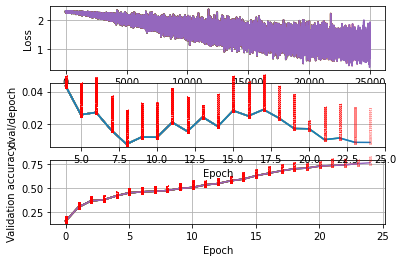

In [12]:
def shuffle(X, Y):
    train_indices = np.arange(X.shape[0])
    np.random.shuffle(train_indices)
    X_result = X[train_indices,:, :]
    Y_result = Y[train_indices]
    return X_result, Y_result

def load_mnist_data():
    with open('mnist.pickle', 'rb') as f:
        print('Loading Pickled Data...')
        return pickle.load(f)

if __name__ == '__main__':
    # Clear old computational graphs
    tf.compat.v1.reset_default_graph()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    with tf.compat.v1.Session(config=config) as sess:

        # fashion_mnist = keras.datasets.fashion_mnist

        (x_train, y_train) , (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train = x_train[:, :, :]
        x_test = x_test[:, :, :]

        #(x_train, y_train), (x_test, y_test) = load_mnist_data()
        # features = features.astype('float32')
        # labels = labels.astype('float32')
        # x_train, y_train = shuffle(features, labels)
        # xx_train = features[::5000, :, :, 0]
        # xy_train = xx_train.copy()
        # y_train = labels[::5000]
        # xx_val = features[5000:6000, :, :, 0]
        # xy_val = xx_val.copy()
        # y_val = labels[5000:6000]
        # xx_test = features[6000:7000, :, :, 0]
        # xy_test = xx_test.copy() 
        # y_test = labels[6000:7000]     

        # # train all
        # x_val = x_train[-10000:, :, :].astype('float64')
        # y_val = y_train[-10000:].astype('float64')
        # xx_train = x_train[:-10000, :, :].astype('float64')
        # xy_train = np.zeros(xx_train.shape).astype('float64') + 1e-15
        # y_train = y_train[:-10000].astype('float64')
        # x_test = x_test.astype('float64')
        # y_test = y_test.astype('float64')

        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)

        # num_train = 35000
        # num_val = 15000
        # num_test = 10000
        num_train = 8000
        num_val = 2000
        num_test = 20000
        xx_val = x_train[-num_val:, :, :].astype('float32')
        xy_val = np.zeros(xx_val.shape).astype('float32') + 1e-50
        y_val = y_train[-num_val:].astype('float32')
        xx_train = x_train[:num_train, :, :].astype('float32')
        xy_train = np.zeros(xx_train.shape).astype('float32') + 1e-50
        y_train = y_train[:num_train].astype('float32')
        xx_test = x_test[:num_test].astype('float32')
        xy_test = np.zeros(xx_test.shape).astype('float32') + 1e-50
        y_test = y_test[:num_test].astype('float32')

        model = d2nn_model()

        sess.run(tf.compat.v1.global_variables_initializer())
        #variables_names = [v.name for v in tf.trainable_variables()]
        #values = sess.run(variables_names)
        #for k, v in zip(variables_names, values):
        #    print( "Variable: ", k)
        #    print("Shape: ", v.shape)
        #    print(v)

        model.train(sess, xx_train, xy_train, y_train, xx_val, xy_val, y_val)
        accuracy, confusion_matrix = model.evaluate(sess, xx_test, xy_test, y_test)
        print(confusion_matrix)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.compat.v1.train.Saver()
        model_path = saver.save(sess, "./d2nn_model_fusion")
        print("Model saved in %s" % model_path)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(pd.DataFrame(confusion_matrix/np.sum(confusion_matrix, axis = 0), range(10), range(10)), annot=True, annot_kws={"size": 16}) # font size
ax.set(xlabel='prediction', ylabel='label', title = 'Fusion Network Confusion Matrix, accuracy = ' + str(accuracy))
plt.show()


In [ ]:
confusion_matrix